In [1]:
import torch as tn
import torchtt as tntt
import TTCME
import matplotlib.pyplot as plt 
import datetime
import numpy as np
import pickle 

tn.set_default_tensor_type(tn.DoubleTensor)
qtt = True

In [2]:
r1m = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->mRNA+protein', 'c1', params = ['c1'])
r2m = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->', 'c2', params = ['c2'])
r3m = TTCME.ChemicalReaction(['mRNA','protein'],'->mRNA', 'c3', params = ['c3'])
r4m = TTCME.ChemicalReaction(['mRNA','protein'],'protein->', 'c4', params = ['c4'])

mdl = TTCME.ReactionSystem(['mRNA','protein'],[r1m, r2m, r3m, r4m], params= ['c1','c2','c3','c4'])

rates = np.array([0.002,0.015,0.1,0.01])
IC = [2,4]
N = [64,64]

In [3]:
with open(r"simplegene_64_500k.pickle", "rb") as input_file:
    dct = pickle.load(input_file) 

No = dct['time_observation'].size
time_observation = dct['time_observation']
reaction_time = dct['reaction_time']
reaction_jumps = dct['reaction_jumps']
reaction_indices = dct['reaction_indices']
observations = dct['observations']
observations_noise = dct['observations_noise']
dT = time_observation[1]-time_observation[0]
sigma = dct['sigma']
sample_posterior_mcmc = dct['sample']

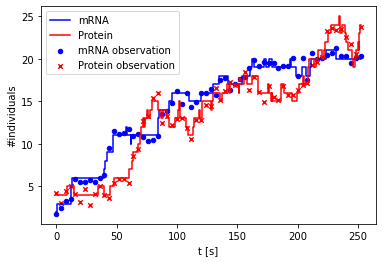

In [4]:
plt.figure()
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,0],2)[:-1],'b')
plt.plot(np.repeat(reaction_time,2)[1:],np.repeat(reaction_jumps[:,1],2)[:-1],'r') 
plt.scatter(time_observation,observations_noise[:,0],c='b',s=20)
plt.scatter(time_observation,observations_noise[:,1],c='r',marker='x',s=20)
plt.xlabel('t [s]')
plt.ylabel('#individuals')
plt.legend(['mRNA','Protein','mRNA observation','Protein observation'])

In [5]:
Nl = 64
mult = 6
param_range = [[0,rc*mult] for rc in rates]
basis_param = [TTCME.basis.BSplineBasis(Nl,[p[0],p[1]],deg = 2) for p in param_range]

In [6]:
mu = rates
var = rates / np.array([1000,350,25,600])
alpha_prior = mu**2/var
beta_prior = mu/var
prior = TTCME.GammaPDF(alpha_prior, beta_prior, basis_param, ['c1','c2','c3','c4'])

In [7]:
p = TTCME.pdf.SingularPMF(N,IC,['mRNA','protein'])
p0 = p**TTCME.pdf.UniformPDF(basis_param)
print(p0)

Probability density function:
p(mRNA,protein)

Basis:

DoF:
TT with sizes and ranks:
N = [64, 64, 64, 64, 64, 64]
R = [1, 1, 1, 1, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 384 compression 5.587935447692871e-09



In [8]:
Att = mdl.generator_tt_galerkin(N, basis_param)